# Predict tags on StackOverflow with linear models

In this assignment you will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Data

The following cell will download all data required for this assignment into the folder `week1/data`.

In [195]:
import sys
sys.path.append("..")
from common.download_stackx import download_stackx_resources

download_stackx_resources()
data_path = "data/stackx"

File data/stackx/train.tsv is already downloaded.
File data/stackx/validation.tsv is already downloaded.
File data/stackx/test.tsv is already downloaded.
File data/stackx/text_prepare_tests.tsv is already downloaded.


### Text preprocessing

For this and most of the following assignments you will need to use a list of stop words. It can be downloaded from *nltk*:

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). Upload the corpora using *pandas* and look at the data:

In [3]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [4]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [5]:
train = read_data('data/stackx/train.tsv')
validation = read_data('data/stackx/validation.tsv')
test = pd.read_csv('data/stackx/test.tsv', sep='\t')

In [6]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [186]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow. In this task you'll write a function, which will be also used in the other assignments. 

**Task** Implement the function *text_prepare* following the instructions.

In [8]:
import re

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
MULTIPLE_SPACE_RE = re.compile('[ ]+')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE, "", text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(MULTIPLE_SPACE_RE, " ", text) # Replace multiple space with single one
    text = " ".join(filter(lambda x: x not in STOPWORDS, text.split(" ")))# delete stopwords from text
    return text

In [10]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [11]:
print(test_text_prepare())

Basic tests are passed.


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [12]:
X_train[:3]
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [13]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

For each tag and for each word calculate how many times they occur in the train corpus. 

**Task (WordsTagsCount).** Find 3 most popular tags and 3 most popular words in the train data

In [20]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

for tags in y_train:
    for tag in tags:
        tags_counts[tag] = tags_counts.get(tag, 0) + 1

for words in X_train:
    for word in words.split():
        words_counts[word] = words_counts.get(word, 0) + 1        



We are assuming that *tags_counts* and *words_counts* are dictionaries like `{'some_word_or_tag': frequency}`. After applying the sorting procedure, results will be look like this: `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]`. The grader gets the results in the following format (two comma-separated strings with line break):

    tag1,tag2,tag3
    word1,word2,word3



In [24]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

print(most_common_tags)
print(most_common_words)

def most_common_tokens(token_counts, n):
    return sorted(token_counts.items(), key=lambda x: x[1], reverse=True)[:n]
    
print(most_common_tokens(tags_counts, 3))
print(most_common_tokens(words_counts, 3))


[('javascript', 19078), ('c#', 19077), ('java', 18661)]
[('using', 8278), ('php', 5614), ('java', 5501)]
[('javascript', 19078), ('c#', 19077), ('java', 18661)]
[('using', 8278), ('php', 5614), ('java', 5501)]


### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. You can test your code using the function *test_my_bag_of_words*.

In [47]:
DICT_SIZE = 5000
most_common_words = most_common_tokens(words_counts, DICT_SIZE)    
WORDS_TO_INDEX = {k[0]: v for v, k in enumerate(most_common_words)}
INDEX_TO_WORDS = {v: k[0] for v, k in enumerate(most_common_words)}
ALL_WORDS = WORDS_TO_INDEX.keys()

# print(most_common_words[:5])
# print(WORDS_TO_INDEX)

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary

        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split():
        i = words_to_index.get(word)
        if(i != None):
            result_vector[i] = 1
    return result_vector


In [50]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [51]:
print(test_my_bag_of_words())

Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute):

In [52]:
from scipy import sparse as sp_sparse

In [54]:
print("[Training Data] Creating Sparse Matrix .... Please Wait..")
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
print("[Tags Data] Creating Sparse Matrix .... Please Wait..")
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
print("[Test Data] Creating Sparse Matrix .... Please Wait..")
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

[Training Data] Creating Sparse Matrix .... Please Wait..
[Tags Data] Creating Sparse Matrix .... Please Wait..
[Test Data] Creating Sparse Matrix .... Please Wait..
X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

**Task 3 (BagOfWords).** For the 11th row in *X_train_mybag* find how many non-zero elements it has. In this task the answer (variable *non_zero_elements_count*) should be a number, e.g. 20.

In [70]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = X_train_mybag.getnnz()
print(non_zero_elements_count)


513508


#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
print(X_train[:5])

['draw stacked dotplot r', 'mysql select records datetime field less specified value', 'terminate windows phone 81 app', 'get current time specific country via jquery', 'configuring tomcat use ssl']


In [209]:
def tfidf_features(X_train, X_val, X_test, token_pattern='(\S+)'):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(token_pattern=token_pattern)
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
#     print(tfidf_vectorizer.get_feature_names())
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it. 

In this case, check whether you have c++ or c# in your vocabulary, as they are obviously important tokens in our tags prediction task:

In [211]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape, len(tfidf_vocab))
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}


(100000,) (30000,) (20000,)
(100000, 54375) (30000, 54375) (20000, 54375) 54375


In [213]:
# print(X_train_tfidf.shape)
assert(tfidf_vocab.get("c++") is not None)
assert(tfidf_vocab.get("c#") is not None)
# print(tfidf_vocab.get("c++"))
# print(X_train_tfidf[:, :])
print(X_train_tfidf[:, tfidf_vocab.get("c++")])

  (13, 0)	0.221904466512
  (130, 0)	0.228347648606
  (208, 0)	0.309602108244
  (288, 0)	0.221740042449
  (499, 0)	0.287892958755
  (536, 0)	0.229979926168
  (679, 0)	0.329340549373
  (870, 0)	0.322338034654
  (874, 0)	0.246392895817
  (951, 0)	0.336892727604
  (956, 0)	0.218038742423
  (999, 0)	0.311132440348
  (1020, 0)	0.349328000635
  (1022, 0)	0.444823168136
  (1055, 0)	0.426553324929
  (1176, 0)	0.243466497498
  (1200, 0)	0.432257662343
  (1226, 0)	0.260889648336
  (1280, 0)	0.237570084191
  (1349, 0)	0.323702365688
  (1360, 0)	0.426996888752
  (1375, 0)	0.328016813178
  (1399, 0)	0.446906461702
  (1408, 0)	0.296298025781
  (1475, 0)	0.380213149652
  :	:
  (98450, 0)	0.262665641296
  (98459, 0)	0.27271837686
  (98491, 0)	0.32696748163
  (98560, 0)	0.219853060113
  (98569, 0)	0.373236714859
  (98709, 0)	0.262849391377
  (98754, 0)	0.209216212638
  (98776, 0)	0.15592969929
  (98837, 0)	0.232554681552
  (98862, 0)	0.188463740536
  (98866, 0)	0.264425570742
  (99057, 0)	0.235960341278

If you can't find it, we need to understand how did it happen that we lost them? It happened during the built-in tokenization of TfidfVectorizer. Luckily, we can influence on this process. Get back to the function above and use '(\S+)' regexp as a *token_pattern* in the constructor of the vectorizer.  

Now, use this transormation for the data and check again.

In [214]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test, token_pattern='(\S+)')
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
assert(tfidf_vocab.get("c++") is not None)
assert(tfidf_vocab.get("c#") is not None)

### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [215]:
from sklearn.preprocessing import MultiLabelBinarizer

In [216]:
print(len(tags_counts.keys()))
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
print(y_train.shape)
print(y_train)
y_train_transformed = mlb.fit_transform(y_train)
y_val_transformed = mlb.fit_transform(y_val)
print(y_train_transformed.shape)

100
(100000,)
[list(['r']) list(['php', 'mysql']) list(['c#']) ...,
 list(['python', 'datetime', 'pandas']) list(['javascript', 'jquery'])
 list(['java', 'list', 'generics'])]
(100000, 100)


Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [217]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [218]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    classif = OneVsRestClassifier(LogisticRegression())
    classif.fit(X_train, y_train)
    
    return classif
  

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [219]:
classifier_mybag = train_classifier(X_train_mybag, y_train_transformed)
classifier_tfidf = train_classifier(X_train_tfidf, y_train_transformed)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [228]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)
print("BoW Input %s Value %s " % (X_train_mybag.shape, X_val_mybag.shape))
print("BoW Predticted %s Scores %s " % (y_val_predicted_labels_mybag.shape, y_val_predicted_scores_mybag.shape))
y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)
print("TF Input %s Value %s " % (X_train_tfidf.shape, X_val_tfidf.shape))
print("TF Predticted %s Scores %s " % (y_val_predicted_labels_tfidf.shape, y_val_predicted_scores_tfidf.shape))

BoW Input (100000, 5000) Value (30000, 5000) 
BoW Predticted (30000, 100) Scores (30000, 100) 
TF Input (100000, 54375) Value (30000, 54375) 
TF Predticted (30000, 100) Scores (30000, 100) 


Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [261]:
print(y_val_predicted_labels_tfidf.shape)
print(y_val_transformed.shape)
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val_transformed)
# print(y_val_predicted_labels_tfidf)
# print(y_val_pred_inversed)
# print(y_val_inversed)

for i in range(20):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

(30000, 100)
(30000, 100)
Title:	Why odbc_exec always fail?
True labels:	php,sql
Predicted labels:	


Title:	Access a base classes variable from within a child class
True labels:	javascript
Predicted labels:	class


Title:	Content-Type "application/json" not required in rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails


Title:	Sessions in Sinatra: Used to Pass Variable
True labels:	ruby,session
Predicted labels:	


Title:	Getting error - type "json" does not exist - in Postgresql during rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	


Title:	library not found for.....?
True labels:	c++,ios,iphone,xcode
Predicted labels:	


Title:	.csproj File - Programmatic adding/deleting files
True labels:	c#
Predicted labels:	


Title:	TypeError: makedirs() got an unexpected keyword argument 'exists_ok'
True labels:	django,python
Predicted labels:	python


Title:	How to Pan a div using JQuery
True labels:	html,javascript,jquery
Predicted labels:	javascri

Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [239]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [262]:
def print_evaluation_scores(y_val, predicted):
    print("Accuracy Score %s" % accuracy_score(y_val, predicted))

In [266]:
print('Bag-of-words')
# print(y_val_transformed)
# print(y_val_predicted_labels_mybag)
print_evaluation_scores(y_val_transformed, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val_transformed, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy Score 0.3617
Tfidf
Accuracy Score 0.3021


You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [251]:
from metrics import roc_auc
%matplotlib inline

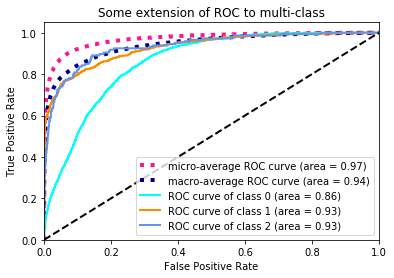

In [252]:
n_classes = len(tags_counts)
roc_auc(y_val_transformed, y_val_predicted_scores_mybag, n_classes)

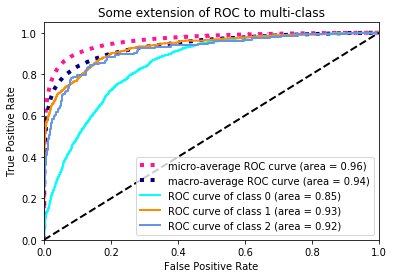

In [254]:
n_classes = len(tags_counts)
roc_auc(y_val_transformed, y_val_predicted_scores_tfidf, n_classes)

**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

You also could try other improvements of the preprocessing / model, if you want. 

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

When you are happy with the quality, create predictions for *test* set

In [260]:
test_predictions = classifier_tfidf.predict(X_val_tfidf)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
print(test_predictions)


0	
1	class
2	ruby-on-rails
3	
4	
5	
6	
7	python
8	javascript,jquery
9	hibernate,java
10	c#
11	
12	php
13	
14	c#,wpf
15	c#,wpf
16	
17	html,javascript,jquery,twitter-bootstrap
18	
19	
20	javascript,php
21	python
22	
23	android,javascript
24	
25	java
26	django,python
27	java
28	ruby-on-rails
29	java
30	ajax,javascript,jquery
31	java
32	
33	c#
34	c
35	php
36	r
37	java
38	c#,linq
39	javascript
40	
41	
42	
43	c#,linq
44	
45	javascript
46	codeigniter,php
47	java
48	php,wordpress
49	
50	php
51	
52	
53	php
54	java
55	django
56	python
57	c++
58	java
59	ruby-on-rails
60	ruby-on-rails
61	javascript
62	android,python
63	
64	
65	c++
66	
67	
68	javascript,jquery
69	c#,linq
70	pandas,python
71	javascript
72	angularjs,javascript
73	
74	java
75	php
76	c#,database,mysql,sql,sql-server
77	asp.net,c#
78	
79	java
80	
81	android,java
82	php
83	ajax,php
84	
85	google-maps,javascript
86	
87	mysql,php
88	java
89	java,spring
90	windows
91	
92	
93	python
94	java
95	
96	c#,wpf
97	asp.net,asp.net-mvc,c#
98	
99	php,

### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

Implement the function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [ ]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    top_positive_words = # top-5 words sorted by the coefficiens.
    top_negative_words = # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [ ]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)